In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")


In [2]:
#%matplotlib inline


Section 1: Data Overview and Preparation

In [3]:
# Section 1: Data Overview and Preparation
    # 0. Load Data
    # 1. Change Data types (the reasoning must be documented)
    # 2. Flag Missing Data
    # 3. Treat Missing Data
    # 4. Visulize Data
    # 5. Outlier detection and removal or capping
    # 6. Feature engineering / transformation (Normalization etc.)
    # 7. Split data into train/test sets
    # 8. Resample if target is imbalanced (Undersampling, or class weights to handle imbalanced fall risk (usually not many patients fall).)

In [4]:
# 0. Load Data
# Load dataset (adjust the filename accordingly)
df = pd.read_csv("kip_sdm_syn.csv", delimiter=",")  # If the delimiter is different, adjust accordingly

# Check dataset size (number of rows and columns)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Check column names, data types, and missing values
df.info()


Number of rows: 40000
Number of columns: 45
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   fallen                                            40000 non-null  bool   
 1   id                                                40000 non-null  int64  
 2   age                                               40000 non-null  int64  
 3   procedure                                         40000 non-null  object 
 4   diagnosis                                         40000 non-null  object 
 5   c_zriserh1                                        40000 non-null  bool   
 6   decubitus-admission                               9399 non-null   object 
 7   decubitus-at_the_moment                           9599 non-null   object 
 8   bed_mobility-impairment                           11

In [5]:
#from IPython.display import display

#display(df.style.set_sticky())  # Keeps headers fixed while scrolling


In [6]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(df, title="Dataset Report", explorative=True)
#profile.to_widgets()  # Display report in Jupyter


In [7]:
# 1. Change Data types (the reasoning must be documented)

import pandas as pd
import numpy as np

# Konvertierung von String zu Boolean (inkl. leere Zellen)
def to_boolean(val):
    if pd.isna(val) or str(val).strip() == "":
        return pd.NA
    val = str(val).strip().lower()
    if val == "true":
        return True
    elif val == "false":
        return False
    else:
        return pd.NA

# Typ-Mapping laut Aufgabenstellung
type_mapping = {
    'procedure': 'category',
    'diagnosis': 'category',
    'decubitus-admission': 'bool',
    'decubitus-at_the_moment': 'bool',
    'bed_mobility-impairment': 'bool',
    'bed_mobility-jones': 'category',
    'bed_mobility-skin_condition': 'bool',
    'transfer-impairment': 'bool',
    'transfer': 'category',
    'medical_items': 'bool',
    'medical_items-skin_condition_at_item_application': 'bool',
    'fall-last_12_month': 'bool',
    'fall-how_many_last_12_month': 'int64',
    'fall-while_stay': 'bool',
    'fall-while_transfer': 'bool',
    'walk-impairment': 'bool',
    'walk-jones': 'category',
    'excretions-impairment': 'bool',
    'cognition-impairment': 'bool',
    'psychotropic_or_sedatives_drugs': 'bool',
    'decubitus-risk': 'category',
    'fall-risk': 'category',
    'diseases': 'bool',
    'sex': 'category'
}

# Protokoll für Konvertierungsaktionen
conversion_log = []

#  Typkonvertierung
for col, new_type in type_mapping.items():
    if col in df.columns:
        original_len = len(df)
        try:
            if new_type == 'category':
                df[col] = df[col].astype('category')

            elif new_type == 'bool':
                df[col] = df[col].apply(to_boolean).astype("boolean")

            elif new_type == 'int64':
                df[col] = pd.to_numeric(df[col], errors='coerce')
                non_integer_mask = df[col].dropna().apply(lambda x: not float(x).is_integer())
                non_integer_indices = df[col].dropna()[non_integer_mask].index
                removed = len(non_integer_indices)
                df.drop(index=non_integer_indices, inplace=True)
                df[col] = df[col].astype("Int64")

                if removed > 0:
                    conversion_log.append(
                        f"Spalte '{col}': {removed} Zeilen mit ungültigen (nicht-ganzzahligen) Werten gelöscht."
                    )

            elif new_type == 'float':
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('Float64')

            elif new_type == 'string':
                df[col] = df[col].astype("string")

        except Exception as e:
            conversion_log.append(f"Spalte '{col}': Fehler bei der Umwandlung – {str(e)}")

# ✅ Fehlende Werte in Boolean-Spalten durch False ersetzen
boolean_cols = df.select_dtypes(include="boolean").columns
df[boolean_cols] = df[boolean_cols].fillna(False)

# 🧾 Protokoll ausgeben
print("🧾 Umwandlungsprotokoll:")
for entry in conversion_log:
    print(" -", entry)

# 🧮 Übersicht anzeigen
df.info()


🧾 Umwandlungsprotokoll:
 - Spalte 'fall-how_many_last_12_month': 15 Zeilen mit ungültigen (nicht-ganzzahligen) Werten gelöscht.
<class 'pandas.core.frame.DataFrame'>
Index: 39985 entries, 0 to 39999
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   fallen                                            39985 non-null  bool    
 1   id                                                39985 non-null  int64   
 2   age                                               39985 non-null  int64   
 3   procedure                                         39985 non-null  category
 4   diagnosis                                         39985 non-null  category
 5   c_zriserh1                                        39985 non-null  bool    
 6   decubitus-admission                               39985 non-null  boolean 
 7   decubitus-at_the_moment                    

In [8]:
# Prüfen und entfernen, wenn nur False enthalten ist
if "decubitus-admission" in df.columns:
    if df["decubitus-admission"].nunique(dropna=False) == 1 and df["decubitus-admission"].unique()[0] == False:
        df.drop(columns="decubitus-admission", inplace=True)
        print("🗑️ Spalte 'decubitus-admission' wurde entfernt (enthielt nur False).")


🗑️ Spalte 'decubitus-admission' wurde entfernt (enthielt nur False).


📊 Verteilung der Zielvariable 'fallen':
        Anzahl  Prozent
fallen                 
False    39891    99.76
True        94     0.24


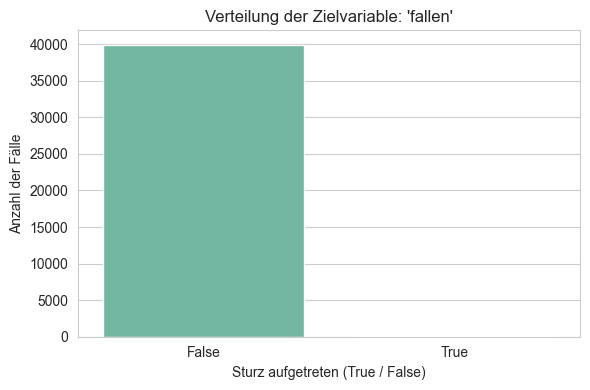

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Absolute Häufigkeiten
fall_counts = df["fallen"].value_counts(dropna=False)

# Relative Häufigkeiten in %
fall_percent = df["fallen"].value_counts(normalize=True, dropna=False) * 100

# Tabelle anzeigen
fall_summary = pd.DataFrame({
    "Anzahl": fall_counts,
    "Prozent": fall_percent.round(2)
})

print("📊 Verteilung der Zielvariable 'fallen':")
print(fall_summary)

# Balkendiagramm
# Balkendiagramm ohne FutureWarning
plt.figure(figsize=(6, 4))
sns.barplot(
    x=fall_counts.index.astype(str),
    y=fall_counts.values,
    hue=fall_counts.index.astype(str),  # Dummy Hue
    palette="Set2",
    legend=False
)
plt.title("Verteilung der Zielvariable: 'fallen'")
plt.xlabel("Sturz aufgetreten (True / False)")
plt.ylabel("Anzahl der Fälle")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

# -> Highly imbalanced target variable will need special Sampling.


C:\Users\DE118418\AppData\Local\Temp\ipykernel_27888\165548051.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_table.iloc[:20, 0], y=missing_table.iloc[:20].index, palette="viridis")


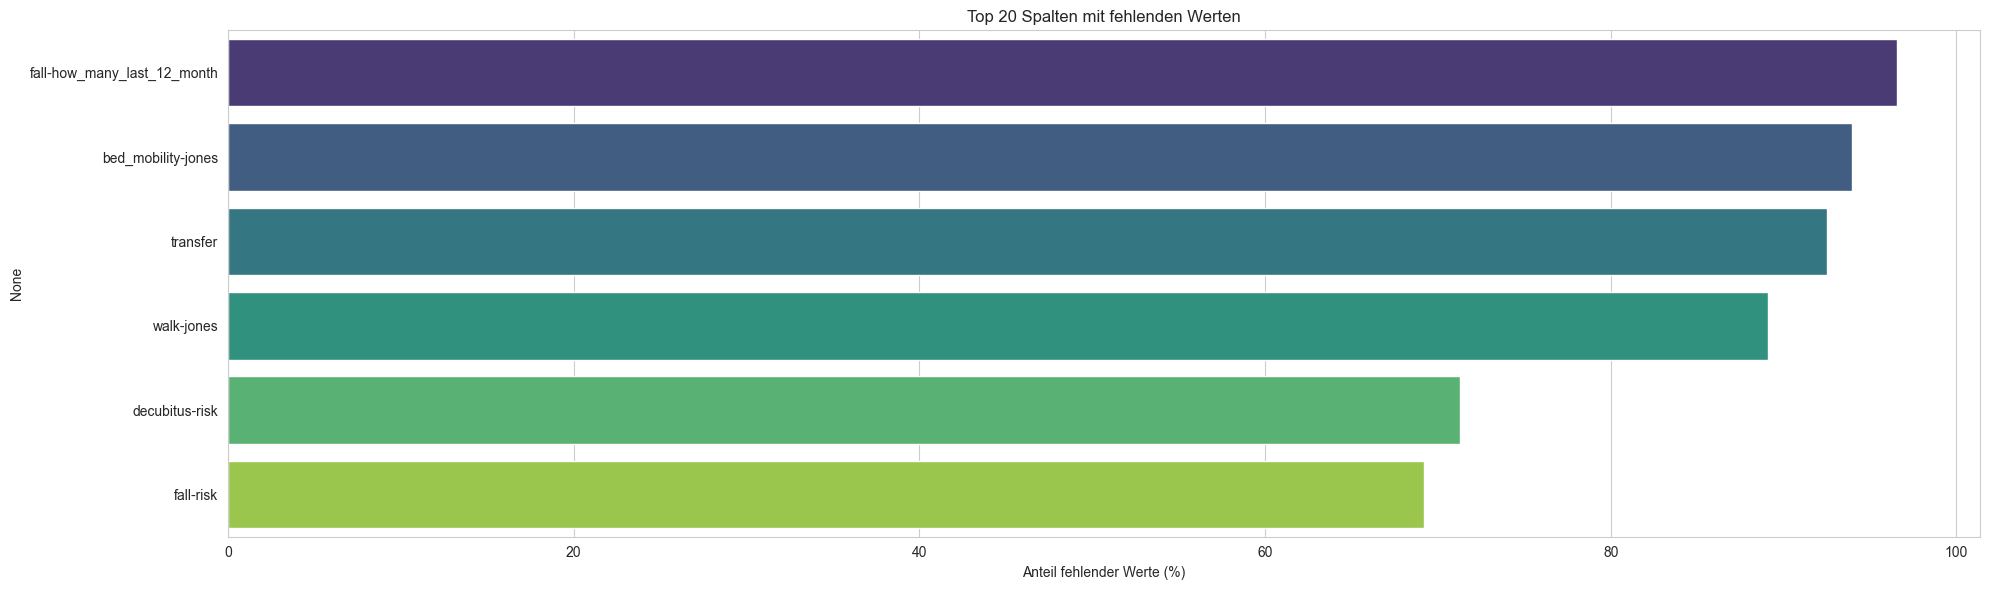

,Missing (%)
fall-how_many_last_12_month,96.536201
bed_mobility-jones,93.985244
transfer,92.484682
walk-jones,89.078404
decubitus-risk,71.289233
fall-risk,69.203451


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fehlende Werte pro Spalte in Prozent
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_table = missing_percent[missing_percent > 0].to_frame(name="Missing (%)")

# Balkendiagramm der Top 20 Spalten mit fehlenden Werten
plt.figure(figsize=(20, 6))
sns.barplot(x=missing_table.iloc[:20, 0], y=missing_table.iloc[:20].index, palette="viridis")
plt.xlabel("Anteil fehlender Werte (%)")
plt.title("Top 20 Spalten mit fehlenden Werten")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

# Tabelle optional anzeigen
display(missing_table)



📊 Übersicht für Spalte: fall-how_many_last_12_month
--------------------------------------------------
🔹 Fehlende Werte: 96.54 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 5

🔸 Wertverteilung:
fall-how_many_last_12_month
<NA>    38600
1        1122
5         249
3          11
2           3
Name: count, dtype: Int64

📊 Übersicht für Spalte: bed_mobility-jones
--------------------------------------------------
🔹 Fehlende Werte: 93.99 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 6

🔸 Wertverteilung:
bed_mobility-jones
NaN    37580
2       1678
3        494
4A       139
1         89
4B         5
Name: count, dtype: int64

📊 Übersicht für Spalte: walk-jones
--------------------------------------------------
🔹 Fehlende Werte: 89.08 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 6

🔸 Wertverteilung:
walk-jones
NaN    35618
2       3084
3        486
1        483
4A       241
4B        73
Name: count, dtype: int64

📊 Übersicht für Spalte: decubitus-risk
---------------------------------

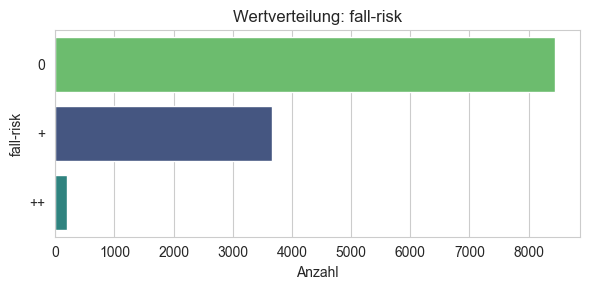

In [11]:
 # 2. Flag Missing Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stil für Diagramme
sns.set_style("whitegrid")

# Zielspalten laut deiner Analyse
columns_to_check = [
    "fall-how_many_last_12_month",
    "bed_mobility-jones",
    "walk-jones",
    "decubitus-risk",
    "fall-risk"
]

# Analyse-Schleife
for col in columns_to_check:
    print(f"\n📊 Übersicht für Spalte: {col}")
    print("-" * 50)
    
    # Fehlende Werte
    missing_pct = df[col].isna().mean() * 100
    print(f"🔹 Fehlende Werte: {missing_pct:.2f} %")

    # Anzahl eindeutiger Werte inkl. NaN
    unique_vals = df[col].nunique(dropna=False)
    print(f"🔹 Anzahl unterschiedlicher Werte (inkl. NaN): {unique_vals}")

    # Verteilung (inkl. NaN)
    print("\n🔸 Wertverteilung:")
    print(df[col].value_counts(dropna=False))

    # Visualisierung für kategoriale Merkmale
   # Visualisierung für kategoriale Merkmale (warnungsfrei)
if df[col].dtype.name == "category":
    plt.figure(figsize=(6, 3))
    sns.countplot(
        data=df,
        y=col,
        order=df[col].value_counts().index,
        hue=col,                  # dummy hue notwendig für palette
        palette="viridis",
        legend=False              # keine doppelte Legende nötig
    )
    plt.title(f"Wertverteilung: {col}")
    plt.xlabel("Anzahl")
    plt.tight_layout()
    plt.show()


In [12]:
# Entfernen der ID-Spalte, da sie keine nützliche Information enthält
if "id" in df.columns:
    df.drop(columns="id", inplace=True)
    print("🗑️ Spalte 'id' wurde entfernt (nur Identifikator, keine Modellrelevanz).")


🗑️ Spalte 'id' wurde entfernt (nur Identifikator, keine Modellrelevanz).


In [26]:
# 1. Numerisch: NaN mit 0 ersetzen
# Neue Spalte: Angabe vorhanden oder nicht
df["fall-how_many_last_12_month_present"] = df["fall-how_many_last_12_month"].notna()

# NaNs durch 0 ersetzen
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].fillna(0).astype("int64")

# 2. Kategorisch: NaN mit "unknown" ersetzen
columns_to_fill_unknown = [
    "bed_mobility-jones",
    "walk-jones",
    "transfer",
    "decubitus-risk",
    "fall-risk"
]

for col in columns_to_fill_unknown:
    df[col] = df[col].cat.add_categories("unknown")  # Kategorie "unknown" hinzufügena
    df[col] = df[col].fillna("unknown")              # NaN ersetzen


AttributeError: Can only use .cat accessor with a 'category' dtype

In [14]:
import sweetviz as sv

# Generate a Sweetviz report
report = sv.analyze(df)

# Display the report in the notebook
report.show_html("sweetviz_report.html")


                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [15]:
# 📊 Übersicht über den Datensatz
print("📊 Intuitive Summary of Dataset:")
print(f"Anzahl Zeilen: {len(df)}")
print(f"Anzahl Spalten: {df.shape[1]}")
print("\n🔹 Spalten nach Datentyp:")
print(df.dtypes.value_counts())
print("\n🔹 Anteil fehlender Werte (Top 10):")
print((df.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))


📊 Intuitive Summary of Dataset:
Anzahl Zeilen: 39985
Anzahl Spalten: 43

🔹 Spalten nach Datentyp:
bool        19
boolean     14
category     3
category     2
int64        1
category     1
category     1
Int64        1
category     1
Name: count, dtype: int64

🔹 Anteil fehlender Werte (Top 10):
fallen                            0.0
cognition-impairment              0.0
fall-while_transfer               0.0
walk-impairment                   0.0
walk-jones                        0.0
walk-balance_and_gait_impaired    0.0
walking_aid                       0.0
excretions-impairment             0.0
excretions-incontinence           0.0
excretions-nykturie               0.0
dtype: float64



📈 Ausreißeranalyse für: age
Q1: 39.00
Q3: 74.00
IQR: 35.00
Lower Bound: -13.50
Upper Bound: 126.50
Anzahl Ausreißer: 0 (0.00%)


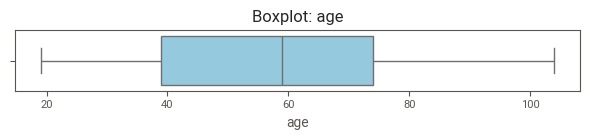


📈 Ausreißeranalyse für: fall-how_many_last_12_month
Q1: 0.00
Q3: 0.00
IQR: 0.00
Lower Bound: 0.00
Upper Bound: 0.00
Anzahl Ausreißer: 1385 (3.46%)


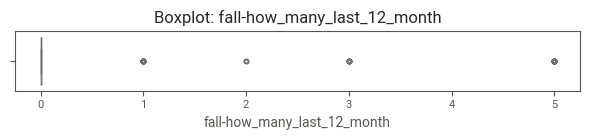

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔍 Ausreißeranalyse mit IQR
for col in ["age","fall-how_many_last_12_month"]:
    if col in df.columns:
        print(f"\n📈 Ausreißeranalyse für: {col}")
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"Q1: {Q1:.2f}")
        print(f"Q3: {Q3:.2f}")
        print(f"IQR: {IQR:.2f}")
        print(f"Lower Bound: {lower_bound:.2f}")
        print(f"Upper Bound: {upper_bound:.2f}")
        print(f"Anzahl Ausreißer: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

        # 📦 Boxplot anzeigen
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], color="skyblue")
        plt.title(f"Boxplot: {col}")
        plt.tight_layout()
        plt.show()


In [17]:
# Crosstab mit relativen Häufigkeiten (Zeilenprozent)
def show_crosstab(col):
    print(f"\n📊 Verteilung von 'fallen' je Kategorie in: {col}")
    ct = pd.crosstab(df[col], df["fallen"], normalize="index") * 100
    display(ct.round(2))

# Analyse für ausgewählte kategoriale Merkmale
for cat_col in ["fall-risk", "decubitus-risk", "walk-jones", "bed_mobility-jones"]:
    if cat_col in df.columns:
        show_crosstab(cat_col)



📊 Verteilung von 'fallen' je Kategorie in: fall-risk


fallen,False,True
fall-risk,,
+,97.44,2.56
++,100.00,0.00
0,100.00,0.00
unknown,100.00,0.00



📊 Verteilung von 'fallen' je Kategorie in: decubitus-risk


fallen,False,True
decubitus-risk,,
+,97.81,2.19
++,97.70,2.30
0,99.90,0.10
unknown,99.92,0.08



📊 Verteilung von 'fallen' je Kategorie in: walk-jones


fallen,False,True
walk-jones,,
1,93.58,6.42
2,99.90,0.10
3,97.53,2.47
4A,96.27,3.73
4B,95.89,4.11
unknown,99.90,0.10



📊 Verteilung von 'fallen' je Kategorie in: bed_mobility-jones


fallen,False,True
bed_mobility-jones,,
1,93.26,6.74
2,99.88,0.12
3,97.17,2.83
4A,95.68,4.32
4B,100.00,0.00
unknown,99.82,0.18


Die ordinalen Merkmale `fall-risk`, `decubitus-risk`, `walk-jones` und `bed_mobility-jones` wurden anhand einer logisch definierten Skala in numerische Werte umgewandelt. 
Werte mit "unknown" wurden als -1 codiert, um sie im Modell als unbekannt, aber explizit markiert, zu belassen.


In [18]:
# 🧠 Ziel: Ordinale Features mit Mapping umwandeln, dabei unbekannte Werte ("unknown" oder ungemappte Werte) als -1 behandeln

ordinal_mappings = {
    "fall-risk": {
        "unknown": -1,
        "0": 0,
        "+": 1,
        "++": 2
    },
    "decubitus-risk": {
        "unknown": -1,
        "0": 0,
        "+": 1,
        "++": 2
    },
    "walk-jones": {
        "unknown": -1,
        "1": 1,
        "2": 2,
        "3": 3,
        "4A": 4
    },
    "bed_mobility-jones": {
        "unknown": -1,
        "1": 1,
        "2": 2,
        "3": 3,
        "4A": 4
    }
}

# ✅ Mapping mit Fehlervermeidung durch fillna(-1)
for col, mapping in ordinal_mappings.items():
    print(f"🔁 Mapping Spalte '{col}' mit: {mapping}")
    df[col] = df[col].map(mapping).fillna(-1).astype("int64")
    print(f"✅ '{col}' erfolgreich konvertiert: dtype = {df[col].dtype}\n")


🔁 Mapping Spalte 'fall-risk' mit: {'unknown': -1, '0': 0, '+': 1, '++': 2}
✅ 'fall-risk' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'decubitus-risk' mit: {'unknown': -1, '0': 0, '+': 1, '++': 2}
✅ 'decubitus-risk' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'walk-jones' mit: {'unknown': -1, '1': 1, '2': 2, '3': 3, '4A': 4}
✅ 'walk-jones' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'bed_mobility-jones' mit: {'unknown': -1, '1': 1, '2': 2, '3': 3, '4A': 4}
✅ 'bed_mobility-jones' erfolgreich konvertiert: dtype = int64



In [19]:
# Optional: Korrektheit prüfen
df[list(ordinal_mappings.keys())].describe()


,fall-risk,decubitus-risk,walk-jones,bed_mobility-jones
count,39985.000000,39985.000000,39985.000000,39985.000000
mean,-0.590371,-0.627710,-0.665700,-0.802851
std,0.674555,0.659186,0.987877,0.795189
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,-1.000000,-1.000000
max,2.000000,2.000000,4.000000,4.000000


In [20]:
import sweetviz as sv

# Generate a Sweetviz report
report = sv.analyze(df)

# Display the report in the notebook
report.show_html("sweetviz_report.html")


                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [27]:
# Test Feature Importance for target Variable

import pandas as pd

feature_importance_df = predictor.feature_importance(test_data)
feature_importance_df.head(20)


These features in provided data are not utilized by the predictor and will be ignored: ['medical_items-A_V_system']
Computing feature importance via permutation shuffling for 41 features using 5000 rows with 5 shuffle sets...
	28.81s	= Expected runtime (5.76s per shuffle set)
	7.25s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
fall-while_stay,0.067974,0.062109,0.035328,5,0.195857,-0.059909
walk-balance_and_gait_impaired,0.067974,0.062109,0.035328,5,0.195857,-0.059909
procedure,0.023529,0.052613,0.186950,5,0.131861,-0.084802
psychotropic_or_sedatives_drugs,0.005869,0.005891,0.044926,5,0.017998,-0.006261
bed_mobility-skin_condition,0.001170,0.002615,0.186950,5,0.006554,-0.004215
excretions-nykturie,0.000000,0.000000,0.500000,5,0.000000,0.000000
fall-while_transfer,0.000000,0.000000,0.500000,5,0.000000,0.000000
walk-impairment,0.000000,0.000000,0.500000,5,0.000000,0.000000
walking_aid,0.000000,0.000000,0.500000,5,0.000000,0.000000
excretions-impairment,0.000000,0.000000,0.500000,5,0.000000,0.000000


In [28]:
# 🔎 Schritt 1: Fallrate pro Procedure-Kategorie berechnen
procedure_fall_rate = df.groupby("procedure")["fallen"].mean()

# 🧾 Optional: Ausgabe der Top/Bottom Prozeduren
print("📈 Prozeduren mit höchster Fallrate:")
print(procedure_fall_rate.sort_values(ascending=False).head())

print("\n📉 Prozeduren mit niedrigster Fallrate:")
print(procedure_fall_rate.sort_values().head())

# 📌 Schritt 2: Neues numerisches Feature erstellen (Fallrate wird gemappt)
df["procedure_fallrate"] = df["procedure"].map(procedure_fall_rate)

# 🧼 Schritt 3: Originalspalte 'procedure' entfernen, falls nicht mehr gebraucht
df = df.drop(columns="procedure")

# ✅ Ergebnis prüfen
print("\n✅ Neues Feature 'procedure_fallrate' erstellt – Beispielwerte:")
print(df[["procedure_fallrate", "fallen"]].head())


📈 Prozeduren mit höchster Fallrate:
procedure
3-22    0.048387
1-85    0.036364
5-65    0.035714
5-80    0.030303
5-90    0.028169
Name: fallen, dtype: float64

📉 Prozeduren mit niedrigster Fallrate:
procedure
0       0.0
5-56    0.0
5-58    0.0
5-59    0.0
5-61    0.0
Name: fallen, dtype: float64

✅ Neues Feature 'procedure_fallrate' erstellt – Beispielwerte:
   procedure_fallrate  fallen
0            0.000000   False
1            0.000000   False
2            0.021127   False
3            0.000000   False
4            0.000000   False


C:\Users\DE118418\AppData\Local\Temp\ipykernel_27888\354958058.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  procedure_fall_rate = df.groupby("procedure")["fallen"].mean()


In [21]:
# Achtung: Braucht ggf. openpyxl installiert → pip install openpyxl
df.to_excel("kip_sdm_cleaned.xlsx", index=False)


Da  ein unausgewogenes Target (fallen):
Verwenden eines stratifizierten Split, um sicherzustellen, dass die Verteilung von fallen in train und test ähnlich ist.



In [22]:
# Installiere imbalanced-learn, falls noch nicht vorhanden
#!pip install imbalanced-learn


In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 🎯 Zielvariable
target = "fallen"

# 📦 Features und Target aufteilen
X = df.drop(columns=target)
y = df[target]

# ✂️ Stratified Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 🔎 Verteilungen vor dem Oversampling überprüfen
print("📊 Verteilung im gesamten Datensatz:")
print(y.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Trainingsset (vor Oversampling):")
print(y_train.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Testset:")
print(y_test.value_counts(normalize=True) * 100)

# 🔄 Oversampling (nur auf Trainingsdaten!)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# ✅ Ergebnis nach Oversampling
print("\n✅ Verteilung im Trainingsset (nach Oversampling):")
print(y_train_resampled.value_counts(normalize=True) * 100)


📊 Verteilung im gesamten Datensatz:
fallen
False    99.764912
True      0.235088
Name: proportion, dtype: float64

📊 Verteilung im Trainingsset (vor Oversampling):
fallen
False    99.765537
True      0.234463
Name: proportion, dtype: float64

📊 Verteilung im Testset:
fallen
False    99.762411
True      0.237589
Name: proportion, dtype: float64

✅ Verteilung im Trainingsset (nach Oversampling):
fallen
False    50.0
True     50.0
Name: proportion, dtype: float64


In [24]:
"""
# Korrelationen mit der Zielvariable 'fallen', sortiert
fallen_corr = corr_matrix["fallen"].drop("fallen").sort_values(ascending=False)

# Nur die Top-N stärksten Korrelationen anzeigen
top_n = 15
top_corr_vars = fallen_corr.abs().sort_values(ascending=False).head(top_n).index

# Heatmap der Top-Korrelationen mit 'fallen'
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix.loc[top_corr_vars, ["fallen"]],
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False
)
plt.title("Stärkste Korrelationen mit Zielvariable 'fallen'")

plt.tight_layout()
plt.show()
"""

'\n# Korrelationen mit der Zielvariable \'fallen\', sortiert\nfallen_corr = corr_matrix["fallen"].drop("fallen").sort_values(ascending=False)\n\n# Nur die Top-N stärksten Korrelationen anzeigen\ntop_n = 15\ntop_corr_vars = fallen_corr.abs().sort_values(ascending=False).head(top_n).index\n\n# Heatmap der Top-Korrelationen mit \'fallen\'\nplt.figure(figsize=(8, 6))\nsns.heatmap(\n    corr_matrix.loc[top_corr_vars, ["fallen"]],\n    annot=True,\n    cmap="coolwarm",\n    fmt=".2f",\n    cbar=False\n)\nplt.title("Stärkste Korrelationen mit Zielvariable \'fallen\'")\n\nplt.tight_layout()\nplt.show()\n'

In [25]:

from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# 1. Split vorbereiten (falls noch nicht geschehen)
target = "fallen"
X = df.drop(columns=target)
y = df[target]

# Achtung: AutoGluon erwartet ein einziges DataFrame mit Target-Spalte
df_autogluon = X.copy()
df_autogluon[target] = y

# 🔁 Jetzt erst: Datentypen korrigieren
df_autogluon = df_autogluon.astype({
    col: 'bool' for col in df_autogluon.select_dtypes(include='boolean').columns
} | {
    col: 'int' for col in df_autogluon.select_dtypes(include='Int64').columns
})

# Optional: Split in Train und Test (20% Testset)
train_data, test_data = train_test_split(df_autogluon, test_size=0.2, stratify=df_autogluon[target], random_state=42)

# 2. Predictor definieren
predictor = TabularPredictor(label=target, eval_metric="f1", verbosity=2).fit(
    train_data=train_data,
    time_limit=600  # z. B. 10 Minuten Training
)

# 3. Modelle vergleichen (Leaderboard)
predictor.leaderboard(test_data, silent=True)


No path specified. Models will be saved in: "AutogluonModels\ag-20250325_104351"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       17.27 GB / 31.71 GB (54.5%)
Disk Space Avail:   201.14 GB / 471.55 GB (42.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.222222,0.153846,f1,0.064775,0.018122,2.364681,0.064775,0.018122,2.364681,1,True,4
1,CatBoost,0.190476,0.000000,f1,0.078747,0.045159,30.940973,0.078747,0.045159,30.940973,1,True,7
2,NeuralNetFastAI,0.170213,0.074074,f1,2.286868,0.192639,100.213015,2.286868,0.192639,100.213015,1,True,10
3,LightGBMXT,0.095238,0.250000,f1,0.054012,0.030000,7.992924,0.054012,0.030000,7.992924,1,True,3
4,WeightedEnsemble_L2,0.095238,0.250000,f1,0.060530,0.036993,10.216563,0.006518,0.006993,2.223639,2,True,14
5,LightGBMLarge,0.076923,0.222222,f1,0.140367,0.029007,8.065023,0.140367,0.029007,8.065023,1,True,13
6,NeuralNetTorch,0.071429,0.000000,f1,0.225086,0.078574,108.351376,0.225086,0.078574,108.351376,1,True,12
7,XGBoost,0.000000,0.000000,f1,0.187100,0.035003,3.852542,0.187100,0.035003,3.852542,1,True,11
8,ExtraTreesEntr,0.000000,0.000000,f1,0.298859,0.224555,3.269639,0.298859,0.224555,3.269639,1,True,9
9,ExtraTreesGini,0.000000,0.000000,f1,0.301921,0.221554,3.132529,0.301921,0.221554,3.132529,1,True,8
